<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Kalman-filter" data-toc-modified-id="The-Kalman-filter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Kalman filter</a></span></li><li><span><a href="#Example-1:-mass-spring-system" data-toc-modified-id="Example-1:-mass-spring-system-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example 1: mass-spring system</a></span></li><li><span><a href="#3.-Example:-Tracking-the-position-of-a-moving-object" data-toc-modified-id="3.-Example:-Tracking-the-position-of-a-moving-object-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Example: Tracking the position of a moving object</a></span></li></ul></div>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
import numpy as np
from scipy.linalg import expm
from numba import njit
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import HTML
from IPython.display import Image
from IPython.display import Math, Latex
try:
    import scienceplots
except:
    ! pip install SciencePlots
    
from utils import set_preferences, genConvGIF, symdisp, round_expr

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = False
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

In [4]:
#from algorithms import estimate_correlation_matrix, estimate_cross_correlation, lms, nlms, lms_newton

# Kalman filter algorithms


## The Kalman filter

In [5]:
#@njit
def kalman_filter(A, C, Rn, Rv, x_init, y):
    """
    Applies the Kalman filter to a series of observations for a system without external inputs.

    The Kalman filter iteratively estimates the state of a linear dynamic system by minimizing 
    the mean squared error. It operates in two steps: a prediction step and an update step.

    System model:
        x[k+1] = A * x[k] + n[k]
        y[k] = C * x[k] + v[k]

    where:
        n[k] ~ Normal(0, Rn)
        v[k] ~ Normal(0, Rv)

    Parameters
    ----------
    A : ndarray
        State transition matrix of shape (N, N).
    C : ndarray
        Observation matrix of shape (L, N).
    Rn : ndarray
        Process noise covariance matrix of shape (N, N).
    Rv : ndarray
        Measurement noise covariance matrix of shape (L, L).
    x_init : ndarray
        Initial state estimate of shape (N, 1).
    y : ndarray
        Array of observations (measurement vectors) with shape (L, M), 
        where each column corresponds to an observation at a time instant.

    Returns
    -------
    x_hat : ndarray
        Array of state estimates with shape (N, M), containing the estimated state after 
        each observation.

    Notes
    -----
    N is the dimension of the state vector; L is the dimension of the observation vector;
    M is the number of measurement samples. The Kalman gain `K` is computed at each time 
    step to optimally balance the prediction with the measurement. `Re_posterior` is updated 
    to refine the state covariance estimate, and an identity matrix.

    """
    # Initialize state and covariance
    x = x_init
    Re_posterior = x_init*x_init.T
    
    # Assume all float variables
    Rv = Rv.astype(np.float64)
    Rn = Rn.astype(np.float64)
    x = x.astype(np.float64)
    C = C.astype(np.float64)       
    
    # Pre-allocate
    x_hat = np.zeros((x_init.shape[0], y.shape[1]), dtype=np.float64)
    I = np.eye(Re_posterior.shape[0], dtype=np.float64)
    
    for ind in range(y.shape[1]):
        y_ = y[:,ind:ind+1]
                
        # Prediction step: E[x[k]|x[k-1]]
        x_prior = A @ x   
        Re_prior = A @ Re_posterior @ A.T + Rn     
               
        # Kalman gain                        
        K = Re_prior @ C.T @ np.linalg.inv(C @ Re_prior @ C.T + Rv)
        
        # Update step: E[x[k]|y[k]]
        x = x_prior + K @ (y_ - C @ x_prior)
        Re_posterior = (I - K @ C) @ Re_prior
                
        # Store estimates
        x_hat[:,ind] = x.flatten()

    return x_hat


## Example 1: mass-spring system

In [6]:
def simulate_mass_spring(dt, total_time, x_init, k, m, σ2):
    """
    Simulate an ideal mass-spring system over time using a state-space model.
    
    Parameters:
    - dt: Time step for the simulation.
    - total_time: Total simulation time.
    - x_init: Initial state vector [position, velocity].
    - k: Spring constant.
    - m: Mass of the object.
    
    Returns:
    - positions: Array of positions over time.
    - velocities: Array of velocities over time.
    """
    # Define the state transition matrix for the mass-spring system
    A = np.array([[0, 1],
                  [-k / m, 0]])
    
    # Discretize A for time step dt (using an approximation)
    A_d = np.eye(2) + A * dt
    
    # Initialize state and lists to store the results
    x = np.array(x_init).reshape(-1, 1)
    
    # Number of steps
    num_steps = int(total_time / dt)
    states = np.zeros((x.shape[0], num_steps))
      
    for ind in range(num_steps):
        # Update the state using the discretized state-space model
        x = A_d @ x + np.random.normal(0, np.sqrt(σ2), x.shape[1])
        states[:,ind] = x.flatten()
    
    return states, A_d

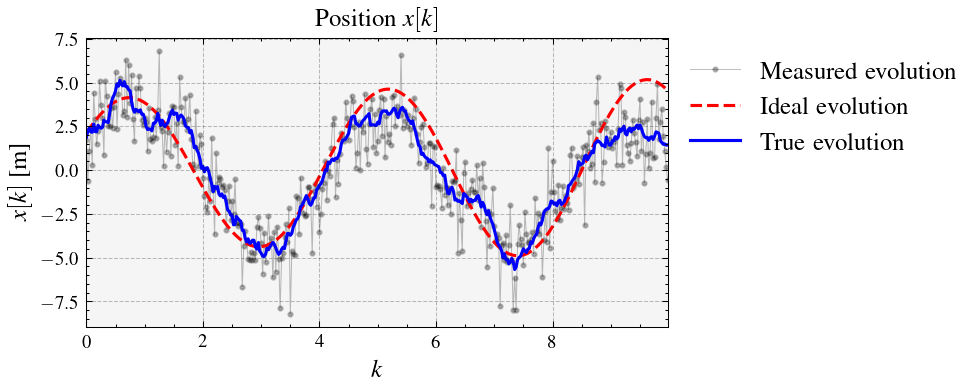

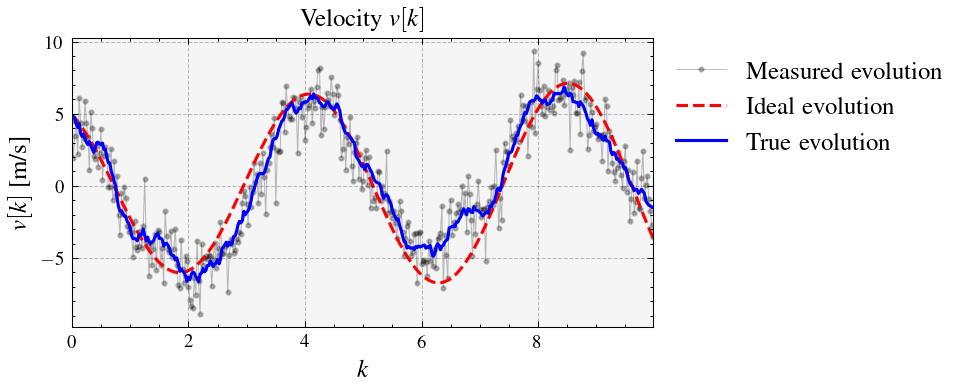

In [7]:
np.random.seed(seed=123)  # fixing the seed to get reproducible results

# Define parameters
dt = 0.025              # Time step in seconds
total_time = 10.0      # Total simulation time in seconds
x_init = np.array([[2.0], [5]])    # Initial position (1 meter) and initial velocity (0 m/s)
k = 2.0                # Spring constant (N/m)
m = 1.0                # Mass (kg)

# process noise
σ2_n = 0.05

# measurement noise
σ2_v = 2

# Simulate the mass-spring system
x, A = simulate_mass_spring(dt, total_time, x_init, k, m, σ2_n)
x_noiseLess, A = simulate_mass_spring(dt, total_time, x_init, k, m, 0)

x_meas = x + np.random.normal(0, np.sqrt(σ2_v), x.shape[1])
t = np.arange(0, total_time, dt)

plt.figure(1)
plt.title('Position $x[k]$')
plt.plot(t, x_meas[0],'-o',linewidth=0.5,alpha=0.25,label='Measured evolution')
plt.plot(t, x_noiseLess[0],linewidth=1.5,label='Ideal evolution')
plt.plot(t, x[0],'-',linewidth=1.5,label='True evolution')
plt.xlim(0,np.max(t))
plt.legend()
plt.grid()
plt.ylabel('$x[k]$ [m]')
plt.xlabel('$k$')
plt.legend(bbox_to_anchor=(1, 1))
#plt.plot(t, dxdt)

plt.figure(2)
plt.title('Velocity $v[k]$')
plt.plot(t, x_meas[1,:],'-o',alpha=0.25, label='Measured evolution')
plt.plot(t, x_noiseLess[1,:],'--', linewidth=1.5,label='Ideal evolution')
plt.plot(t, x[1,:],'-', linewidth=1.5, label='True evolution')
plt.xlim(0,np.max(t))
plt.ylabel('$v[k]$ [m/s]')
plt.xlabel('$k$')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();

In [8]:
print('Matrices of the discrete model:')
symdisp('\\boldsymbol{A} =', sp.Matrix(A))

C = np.array([[1, 0],[0, 1]])
symdisp('\\boldsymbol{C} =', sp.Matrix(C))

print('Space-state equations of the discrete model:')
symdisp('\\boldsymbol{x}[k+1] ='+ sp.latex(sp.Matrix(A))+'\\boldsymbol{x}[k] + \\boldsymbol{n}[k]', )
symdisp('\\boldsymbol{y}[k] ='+ sp.latex(sp.Matrix(C))+'\\boldsymbol{x}[k] + \\boldsymbol{v}[k]', )

Matrices of the discrete model:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Space-state equations of the discrete model:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
print('Initialization of parameters:')

Rn = σ2_n*np.eye(x_init.shape[0])
symdisp('\\boldsymbol{R}_n =', sp.Matrix(Rn))

Rv = σ2_v * np.eye(len(x_init))
symdisp('\\boldsymbol{R}_v =', sp.Matrix(Rv))

x_init = np.array([[0.0], [0.0]])
symdisp('\\boldsymbol{x}[-1] =', sp.Matrix(x_init))

Re_posterior_init = x_init@x_init.T
symdisp('\\boldsymbol{R}_{\\epsilon}[-1] =', sp.Matrix(Re_posterior_init))

Parâmetros de inicialização do:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

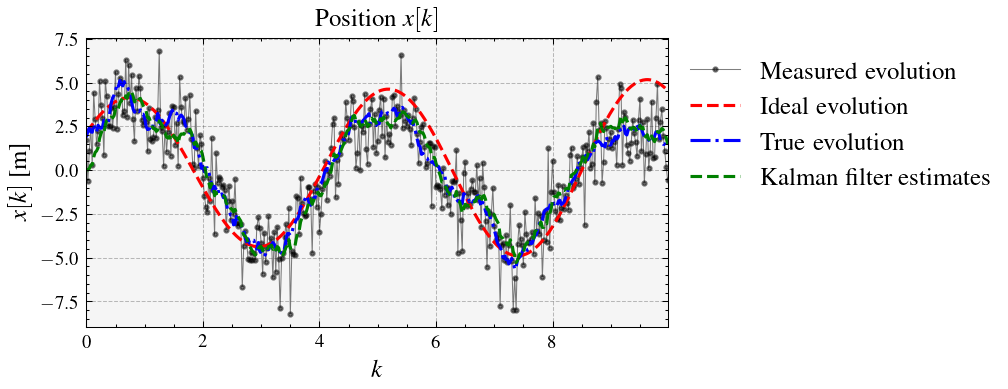

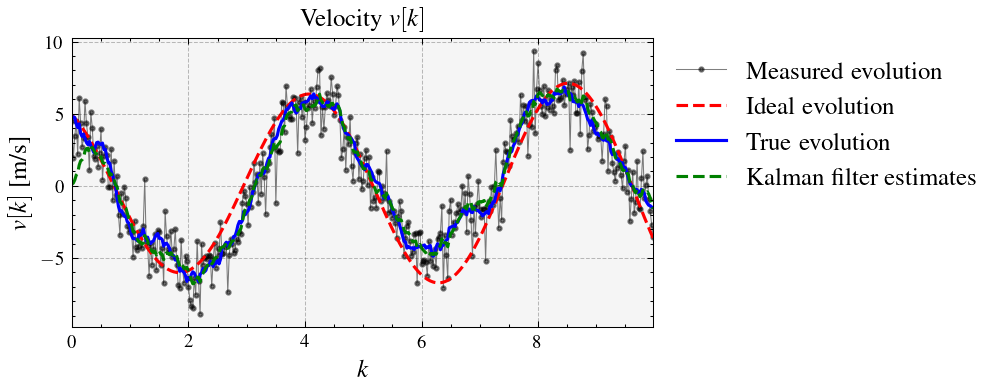

In [10]:
# Run Kalman filter algorithm
x_kalman = kalman_filter(A, C, Rn, Rv, x_init, x_meas)

plt.figure(1)
plt.title('Position $x[k]$')
plt.plot(t, x_meas[0,:],'-o',alpha=0.50, label='Measured evolution')
plt.plot(t, x_noiseLess[0,:],'--', linewidth=1.5,label='Ideal evolution')
plt.plot(t, x[0,:],'-.', linewidth=1.5, label='True evolution')
plt.plot(t, x_kalman[0,:],'--',linewidth=1.5,label='Kalman filter estimates')
plt.xlim(0,np.max(t))
plt.ylabel('$x[k]$ [m]')
plt.xlabel('$k$')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();

plt.figure(2)
plt.title('Velocity $v[k]$')
plt.plot(t, x_meas[1,:],'-o',alpha=0.50, label='Measured evolution')
plt.plot(t, x_noiseLess[1,:],'--', linewidth=1.5,label='Ideal evolution')
plt.plot(t, x[1,:],'-', linewidth=1.5, label='True evolution')
plt.plot(t, x_kalman[1,:],'--',linewidth=1.5,label='Kalman filter estimates')
plt.xlim(0,np.max(t))
plt.ylabel('$v[k]$ [m/s]')
plt.xlabel('$k$')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid();

## 3. Example: Tracking the position of a moving object

In [11]:
def calculate_position_velocity(accelerations, delta_t, initial_position=(0, 0), initial_velocity=(0, 0)):
    """
    Calculates position and velocity over time given accelerations, time step, and initial conditions.
    
    Parameters:
    - accelerations: Array of shape (N, 2) with accelerations [a_x, a_y] at each time step.
    - delta_t: Time step between measurements.
    - initial_position: Tuple (x0, y0) representing initial position in x and y.
    - initial_velocity: Tuple (vx0, vy0) representing initial velocity in x and y.
    
    Returns:
    - positions: Array of shape (N+1, 2) with positions [x, y] over time.
    - velocities: Array of shape (N+1, 2) with velocities [vx, vy] over time.
    """
    # Number of time steps
    N = len(accelerations)
    
    # Initialize arrays for positions and velocities
    positions = np.zeros((N + 1, 2))
    velocities = np.zeros((N + 1, 2))
    
    # Set initial conditions
    positions[0] = initial_position
    velocities[0] = initial_velocity
    
    # Iterate over each time step
    for i in range(1, N + 1):
        # Update velocity: v = v_prev + a * delta_t
        velocities[i] = velocities[i - 1] + accelerations[i - 1] * delta_t
        
        # Update position: x = x_prev + v_prev * delta_t + 0.5 * a * delta_t^2
        positions[i] = positions[i - 1] + velocities[i - 1] * delta_t + 0.5 * accelerations[i - 1] * delta_t ** 2
    
    return positions, velocities

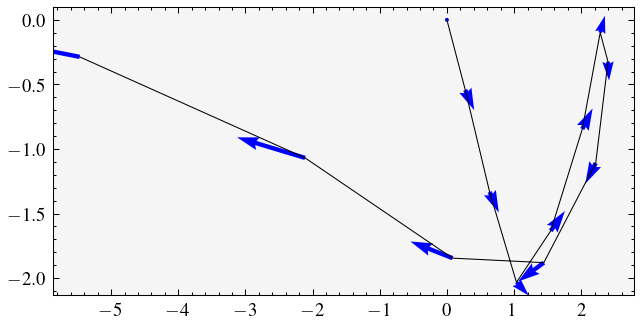

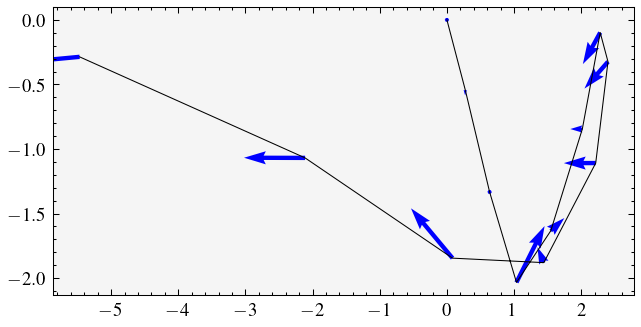

In [217]:

dx = 0.1
x = np.arange(0,12, dx)
ax = 100*np.exp(-5*np.sin(10*x)**2)*np.cos(x)**2 - x**2
ay = -200*np.exp(-5*np.sin(x)**2)*np.cos(x) # + 0.1*x**3

#ax = 100*np.cos(3*x)
#ay = 100*np.sin(x)
#ax[:] = 0.5
#ay[:] = 1
accelerations = np.array([ax, ay]).T
initial_position = (0, 0)
initial_velocity = (1, 1)
Δt = 0.01  # Sampling interval (e.g., in seconds)

positions, velocities = calculate_position_velocity(accelerations, Δt, initial_position, initial_velocity)

#plt.figure()
#plt.plot(ax)
#plt.plot(ay)

# Calculate speed in each component
vx = velocities[:, 0]  # x-component of speed
vy = velocities[:, 1]  # y-component of speed

# Calculate acceleration in each component
ax = np.diff(vx) / Δt  # x-component of acceleration
ay = np.diff(vy) / Δt  # y-component of acceleration

# Optional: Padding to make speed and acceleration arrays match the length of positions
vx = np.concatenate(([0], vx))  # Assuming starting speed is zero
vy = np.concatenate(([0], vy))  # Assuming starting speed is zero

velocity = np.array([vx, vy]).T

ax = np.concatenate(([0, 0], ax))  # Assuming starting speed is zero
ay = np.concatenate(([0, 0], ay))  # Assuming starting speed is zero

plt.figure()
plt.plot(positions[::10, 0], positions[::10, 1])
plt.quiver(positions[::10, 0], positions[::10, 1], vx[::10], vy[::10], color='b', units='xy') 
plt.figure()
plt.plot(positions[::10, 0], positions[::10, 1])
plt.quiver(positions[::10, 0], positions[::10, 1], ax[::10], ay[::10], color='b', units='xy') 

In [218]:
# Define the matrix A for constant acceleration in 2D
A = np.array([[1.0, 0, Δt, 0, (1/2)*Δt**2, 0],  # dx/dt = vx
              [0, 1.0, 0, Δt, 0, (1/2)*Δt**2],  # dy/dt = vy
              [0, 0, 1.0, 0, Δt, 0],  # dvx/dt = ax
              [0, 0, 0, 1.0, 0, Δt],  # dvy/dt = ay
              [0, 0, 0, 0, 0, 1],  # dax/dt = 0
              [0, 0, 0, 0, 0, 1]   # day/dt = 0
             ])

# Define the matrix C for observing position in 2D
C = np.array([
    [1.0, 0, 0, 0, 0, 0],  # Observation of x position
    [0, 1.0, 0, 0, 0, 0]   # Observation of y position
])

# Variances for process noise in each state variable (positions, velocities, accelerations)
sigma_x2 = 0.8  # variance in x position
sigma_y2 = 0.8  # variance in y position
sigma_vx2 = 0.01  # variance in x velocity
sigma_vy2 = 0.01  # variance in y velocity
sigma_ax2 = 0.25  # variance in x acceleration
sigma_ay2 = 0.25  # variance in y acceleration

# Process noise covariance matrix Rn
Rn = 0.005*np.diag([sigma_x2, sigma_y2, sigma_vx2, sigma_vy2, sigma_ax2, sigma_ay2])

# Variances for measurement noise in each observed variable (positions only)
sigma_meas_x2 = 0.25  # variance in x position measurement
sigma_meas_y2 = 0.25  # variance in y position measurement

# Measurement noise covariance matrix Rv
Rv = np.diag([sigma_meas_x2, sigma_meas_y2])

x_init = np.array([[0,0,0,0,0,0]]).T
x_meas = positions.T + np.random.normal(0,np.sqrt(sigma_meas_x2), (2,len(positions)))

In [219]:
print('Matrices of the discrete model:')
symdisp('\\boldsymbol{A} =', sp.Matrix(A))
symdisp('\\boldsymbol{C} =', sp.Matrix(C))

print('Space-state equations of the discrete model:')
symdisp('\\boldsymbol{x}[k+1] ='+ sp.latex(sp.Matrix(A))+'\\boldsymbol{x}[k] + \\boldsymbol{n}[k]', )
symdisp('\\boldsymbol{y}[k] ='+ sp.latex(sp.Matrix(C))+'\\boldsymbol{x}[k] + \\boldsymbol{v}[k]', )

print('Initialization of parameters:')

symdisp('\\boldsymbol{R}_n =', sp.Matrix(Rn))
symdisp('\\boldsymbol{R}_v =', sp.Matrix(Rv))
symdisp('\\boldsymbol{x}[-1] =', sp.Matrix(x_init))

Matrices of the discrete model:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Space-state equations of the discrete model:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Initialization of parameters:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [220]:
# Run Kalman filter algorithm
x_kalman = kalman_filter(A, C, Rn, Rv, x_init, x_meas)

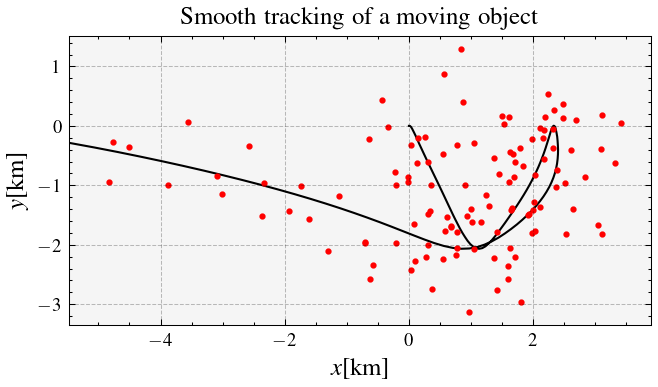

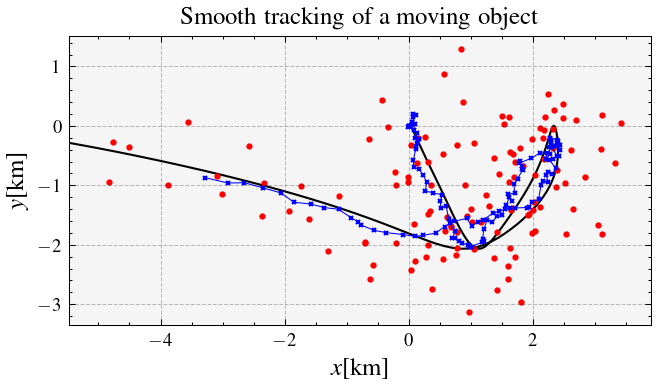

In [221]:
plt.title('Smooth tracking of a moving object')
plt.plot(positions[:, 0], positions[:, 1],'-', linewidth=1)
plt.plot(x_meas[0, :], x_meas[1, :],'o')
plt.xlim(np.min(positions[:, 0]))
plt.xlabel('$x$[km]')
plt.ylabel('$y$[km]')
plt.grid()

plt.figure()
plt.title('Smooth tracking of a moving object')
plt.plot(positions[:, 0], positions[:, 1],'-', linewidth=1)
plt.plot(x_meas[0, :], x_meas[1, :],'o')
plt.plot(x_kalman[0, :], x_kalman[1, :],'-x')
plt.xlim(np.min(positions[:, 0]))
plt.xlabel('$x$[km]')
plt.ylabel('$y$[km]')
plt.grid()

# plt.figure()
# plt.title('Smooth tracking of a moving object')
# plt.plot(vx,'-', linewidth=1)
# plt.plot(vy,'-', linewidth=1)
# #plt.plot(x_meas[0, :], x_meas[1, :],'o')
# plt.plot(x_kalman[2, :],'-x')
# plt.plot(x_kalman[3, :],'-o')
# plt.ylabel('$v_x$[km/s]')
# plt.xlabel('$k$')
# plt.grid()